# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Скачайте его кстати, 

```(bash)
mkdir cifar10
curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xvzf cifar-10-python.tar.gz -C cifar10
```

In [20]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [21]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

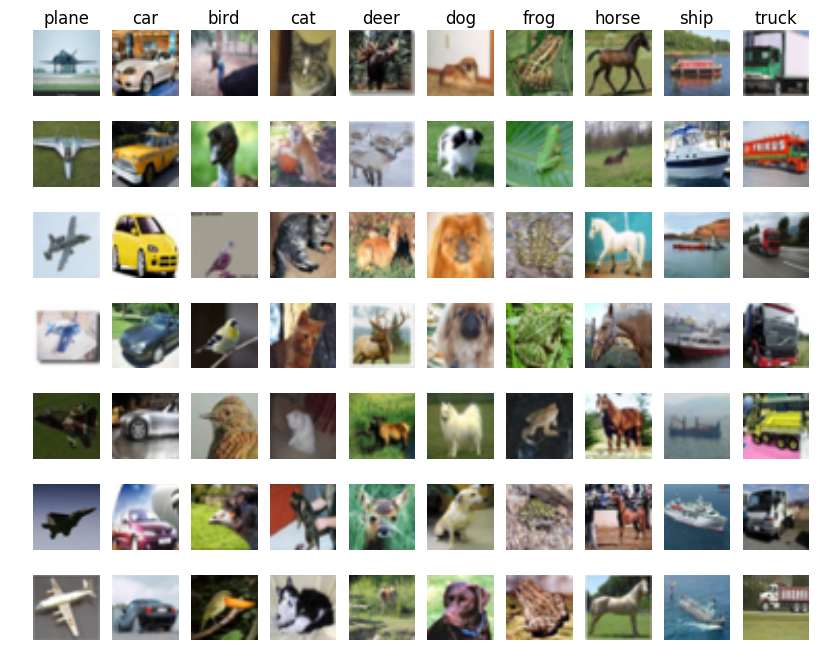

In [22]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').reshape(32, 32, 3))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [23]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *
from lasagne.layers import Conv2DLayer, DenseLayer

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int64')

In [24]:
X_train.shape

(50000, 32, 32, 3)

Так задаётся архитектура нейронки

In [25]:
input_layer = lasagne.layers.InputLayer(shape=(None,3, 32, 32), input_var=input_X)
nnet = Conv2DLayer(input_layer,  num_filters=7, filter_size=(5,5))

dense_output = lasagne.layers.DenseLayer(nnet,num_units = 10, nonlinearity=softmax)

In [26]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output)

In [27]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print all_weights

[W, b, W, b]


### дальше вы могли бы просто
* задать функцию ошибки вручную
* посчитать градиент ошибки по all_weights
* написать updates
* но это долго, а простой шаг по градиенту - не самый лучший смособ оптимизировать веса

Вместо этого, опять используем lasagne

In [28]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

updates_sgd = lasagne.updates.adam(loss, all_weights,learning_rate=0.01)

In [29]:
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates_sgd)
accuracy_fun = theano.function([input_X,target_y],accuracy)

### Вот и всё, пошли её учить

In [30]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [31]:
import time

num_epochs = 10 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

RuntimeError: BaseCorrMM: Failed to allocate output of 50 x 7 x 28 x -1
Apply node that caused the error: CorrMM{valid, (1, 1)}(X, Subtensor{::, ::, ::int64, ::int64}.0)
Toposort index: 9
Inputs types: [TensorType(float64, 4D), TensorType(float64, 4D)]
Inputs shapes: [(50, 32, 32, 3), (7, 3, 5, 5)]
Inputs strides: [(24576, 256, 8, 8192), (600, 200, -40, -8)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Elemwise{add,no_inplace}(CorrMM{valid, (1, 1)}.0, InplaceDimShuffle{x,0,x,x}.0), Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}[(0, 2)](TensorConstant{(1, 1, 1, 1) of 0.5}, Elemwise{add,no_inplace}.0, CorrMM{valid, (1, 1)}.0, InplaceDimShuffle{x,0,x,x}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/Users/Ahan/anaconda/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/Ahan/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/Ahan/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/Ahan/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-251198cc175e>", line 2, in <module>
    y_predicted = lasagne.layers.get_output(dense_output)
  File "/Users/Ahan/anaconda/lib/python2.7/site-packages/lasagne/layers/helper.py", line 191, in get_output
    all_outputs[layer] = layer.get_output_for(layer_inputs, **kwargs)
  File "/Users/Ahan/anaconda/lib/python2.7/site-packages/lasagne/layers/conv.py", line 330, in get_output_for
    conved = self.convolve(input, **kwargs)
  File "/Users/Ahan/anaconda/lib/python2.7/site-packages/lasagne/layers/conv.py", line 608, in convolve
    filter_flip=self.flip_filters)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

## Заполните форму

https://goo.gl/forms/FsANPB1jSqmX1JBJ3